# Modelling and Data Analysis
## Exercise 3
##### *author: Elena Volpert*

### task 1 :First steps on GitHub
I will call the remote repository on the GitHub - global and on the Teaching Hub - local. <br>

`git clone URL` - clone the repository from GitHub to my local repository on the Teaching Hub <br>
`git checkout -b 'ex3'` - create new branch named *ex3* <br>
`git status` - check status (what was created but not pushed or not committed) <br>
`git add 'filename'` - say which file I would like to add to the GitHub repository (which changes I want to track) <br>
`git commit` - commit (fix) the changes, which I added in the further step <br>
    OR <br>
`git commit -m 'message'` - commit and comment changes <br>
`git push` - push changes to GitHub from the local repository <br>
`git pull` - download content from GitHub to local repository and merge it with content existing on the local repository <br>
---

In [467]:
''' LIBRARIES '''

''' basic '''
import numpy as np
import xarray as xr
# plot
import matplotlib.pyplot as plt
import cartopy as cpy
# save variable into file
import pickle as pickle
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

''' local application '''
# compare ERA5 and CMIP6
from scipy import interpolate
# calculate PCA
from sklearn.decomposition import PCA
# unit testing
from numpy import testing
# formatting ticks
import matplotlib.ticker as mtick

''' custom functions application '''
# operate with CMIP6
import fcmip6 as cmip6
# plot routine
import plotmap as pm

### task 2: Map plots

##### ERA 5

In [4]:
filedir = "/users/students/lehre/mda_ws2022/data/"  # directory of ERA5 dataset
erafile = filedir + "era5_2m_temperature_1950-2021_monthly.nc"  # ERA5 dataset
era = xr.open_dataset(erafile)  # open ERA 5 file

In [468]:
with open('climera.pkl', 'rb') as infile:
    climera = pickle.load(infile)

##### CMIP6

In [470]:
# find 4 CMIP6 historical models
# ssp585, because historical is only until 2014
# our period: 1970 - 2020
query = dict(
    experiment_id=['historical', 'ssp585'],
    variable_id=['tas'],
    table_id=['Amon'],
    source_id=['CIESM', 'MIROC6', 'EC-Earth3', 'CMCC-ESM2'],
    member_id=['r1i1p1f1']
)

climmodel = cmip6.download(query, 1970, 2020)

[########################################] | 100% Completed | 8.60 ss


##### Differences

In [471]:
# interpolate ERA5 to CMIP6 model grid
Iclimera = climera.interp(
    latitude=climmodel.lat,
    longitude=climmodel.lon,
    method='nearest'
).drop(['latitude', 'longitude'])

In [7]:
Bclimmodel = []
bias = np.zeros(len(climmodel.model)) + np.nan
RMSE = np.zeros(len(climmodel.model)) + np.nan
for m in np.arange(len(climmodel.model)):

    model = climmodel.sel(model=climmodel.model[m])

    # fill NaN
    maskna = np.ma.masked_invalid(model.tas.values)
    xx, yy = np.meshgrid(model.lon, model.lat)

    model.tas.values = interpolate.griddata(
        (xx[~maskna.mask], yy[~maskna.mask]),
        maskna[~maskna.mask],
        (xx, yy),
        method='nearest')

    # new variables with difference -> lat-lon coords
    model = model.assign(
        {'difference': (
            ('lat', 'lon'),
            np.subtract(model.tas.values, Iclimera.t2m.values)
        )
        }
    )

    # calculate bias and RMSE
    bias[m] = model['difference'].mean()
    RMSE[m] = np.sqrt(np.square(model['difference']).mean())

    Bclimmodel.append(model)

Bclimmodel = xr.concat(Bclimmodel, join='outer', dim='model')

# new variables with bias and RMSE -> model coords
Bclimmodel = Bclimmodel.assign(
    {'bias': ('model', bias),
     'RMSE': ('model', RMSE)}
)

In [472]:
with open('Bclimmodel.pkl', 'rb') as infile:
    Bclimmodel = pickle.load(infile)

##### Plot

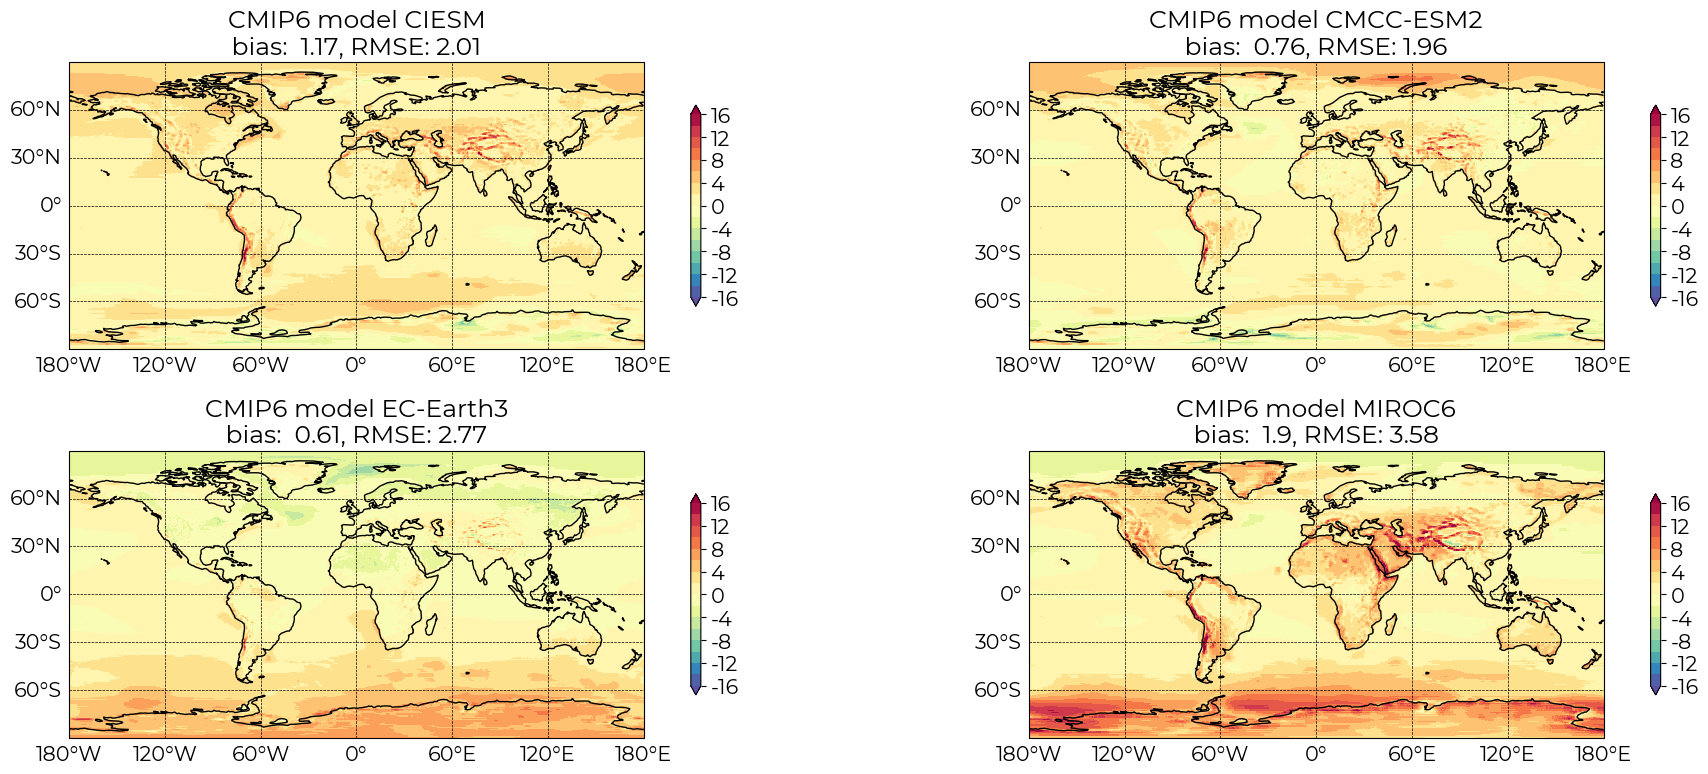

In [473]:
f1, axes = plt.subplots(2, 2,
                        figsize=(20, 8),
                        subplot_kw={'projection': cpy.crs.PlateCarree()})
axes = axes.flatten()

for i, axe in enumerate(axes):
    onemodel = Bclimmodel.sel(model=Bclimmodel.model[i])

    pm.plot_map(onemodel.difference,
                ax=axe,
                colormax=16, colormin=-16, colorlevels=17,
                title=f'CMIP6 model {str(onemodel.model.values)}'
                + f'\n bias:  {round(float(onemodel.bias),2)},'
                + f' RMSE: {round(float(onemodel.RMSE),2)} ')

f1.tight_layout();

In [474]:
# save plot
f1.savefig('CMIP6_and_ERA5.png', format='png', dpi=150)

In [8]:
# docstring
print(pm.plot_map.__doc__)

Plot 2D field with lon-lat grid.

        Call signature::

            plot_map(ds, **kwargs)

            use contourf function from matplotlib.pyplot.
            Could be used for subplots plot due to ax argument.

        Parameters
        ----------
        ds : 2D xarray.DataArray
        The values over which the contour is drawn.

        *ds* must be 2D array with lon-lat coordinates.
        The structure of *ds*:
            ds.coords:
                    lat - 1D array with ``len(lat) == N``, float
                    lon - 1D array with ``len(lon) == M``, flot
                    ds.values -  (N,M) array

        Returns
        -------
        `~.contourf(ds.lon, ds.lat, ds.values)`

        Other Parameters
        ----------------
        ax : a single `~matplotlib.axes.Axes` object, default: None
            Could be used to plot with `~plt.subplots`.

            If not specified:
            ax = plt.axes(projection = cartopy.crs.PlateCarree())

        lat : str, 

### task 3: Principal component analysis

In [5]:
def annual_mean(arr):
    ''' calculate annual mean accounting days in month '''
    # get array containing days in each month
    monlen = arr.time.dt.days_in_month
    # calculate the weights
    weights_month = monlen / monlen.sum()
    # calculate weighted mean
    arrmean = arr.weighted(weights_month).mean("time", keep_attrs=True)
    return arrmean

In [21]:
# calculate annual mean temperature from ERA 5
annualera = era.t2m.groupby("time.year").apply(annual_mean)

In [84]:
with open('annualera.pkl', 'rb') as infile:
    annualera = pickle.load(infile)

In [53]:
# to decouple Europa -> problem with west longitudes
# from 0:360 to -180:180
annualera = annualera.assign_coords(
    {'longitude':
     xr.where(
         annualera.longitude > 180,
         annualera.longitude - 360,
         annualera.longitude)})
annualera = annualera.sortby('longitude')  # 0:180:-180 to -180:0:180

In [360]:
# select region: Europe
lat1 = 35
lat2 = 75
lon1 = -10
lon2 = 40

region = annualera.sel(
    latitude=slice(lat2, lat1),
    longitude=slice(lon1, lon2)
)

##### PCA

In [361]:
# reshape from |year x lat x lon| to |year x (lat*lon)|
regionreshape = region.values.reshape(len(region.year), -1)

# calculate PCA
pca = PCA()
pca.fit(regionreshape)
# eigenvalues, ratio
eigenvalues = pca.explained_variance_ratio_  # |loadings|
# eigenvectors or loadings
loadings = pca.components_  # |loadings x (lat*lon)|
# scores
scores = pca.transform(regionreshape)  # |year x loadings|

# add new variables containing loadings
region = region.to_dataset()
region.coords['eigenvalues'] = eigenvalues
region = region.assign(
    {'pca_loadings': (
        ('eigenvalues', 'latitude', 'longitude'),
        loadings.reshape(region.t2m.values.shape)
    )})

##### Plot

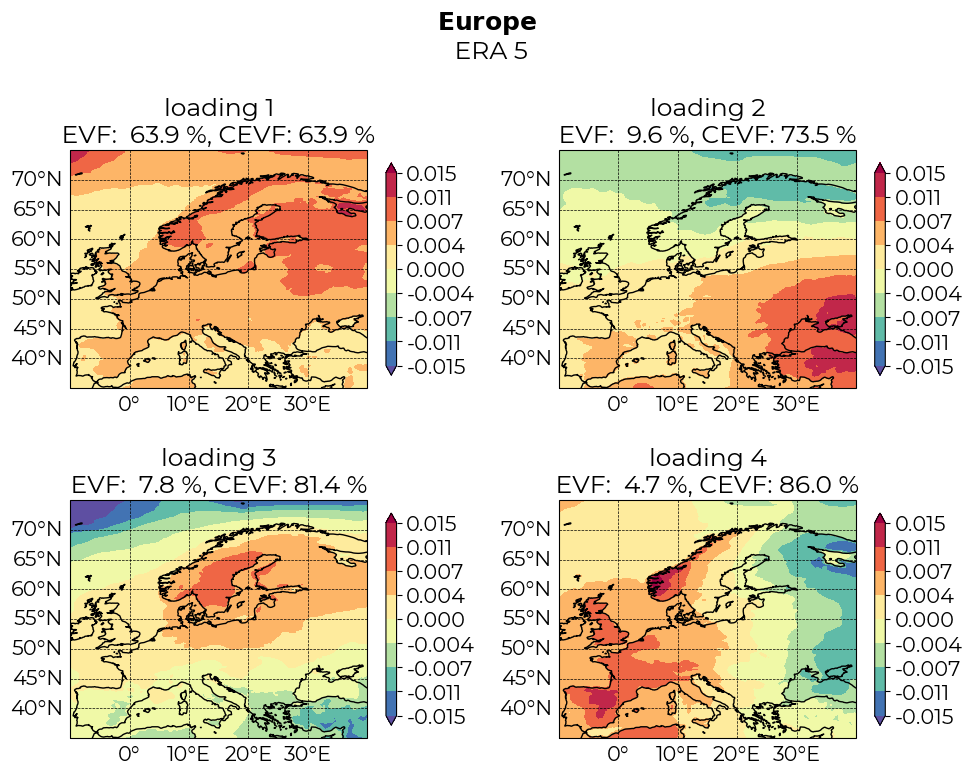

In [82]:
reg = 'Europe'

f2, axes = plt.subplots(2, 2,
                        figsize=(10, 8),
                        subplot_kw={'projection': cpy.crs.PlateCarree()})
axes = axes.flatten()

for i, axe in enumerate(axes):
    oneload = region.sel(eigenvalues=region.eigenvalues[i])

    pm.plot_map(oneload.pca_loadings,
                ax=axe,
                extent=[lon1, lon2, lat1, lat2],
                lat='latitude', lon='longitude',
                fr='%.3f',
                colormax=0.015, colormin=-0.015, colorlevels=9,
                title=f'loading {i+1}'
                + f'\n EVF:  {round(eigenvalues[i]*100,1)} %,'
                + f' CEVF: {round(eigenvalues[:(i+1)].sum()*100,1)} % ')

plt.suptitle(r"$\bf{" + str(reg) + "}$ \n ERA 5")

f2.tight_layout();

In [443]:
f2.savefig('PCA_ERA5.png', format='png', dpi=150)

### task 4: Unit testing

##### Reconstruction

In [ ]:
# regionreshape -> |year x (lat*lon)|
# mean('year') t2m |(lat*lon)|
meanreg = regionreshape.mean(axis=0)
# reconstructed t2m -> |year x (lat*lon) x loadings|
rec = np.zeros((regionreshape.shape[0],
                regionreshape.shape[1],
                loadings.shape[0])) + np.nan
for load in range(loadings.shape[0]):
    for grid in range(meanreg.shape[0]):
        L = load + 1  # because [:L]
        rec[:, grid, load] = meanreg[grid]
        + np.sum(scores[:, :L] * loadings[:L, grid], axis=1)

##### Example

In [373]:
# add new variables containing reconsturcted t2m
region = region.assign(
    {'pca_recostructed': (
        ('year', 'latitude', 'longitude', 'eigenvalues'),
        rec.reshape((region.year.shape[0],
                     region.latitude.shape[0],
                     region.longitude.shape[0],
                     region.eigenvalues.shape[0]))
    )})
regionmean = region.mean('year')

In [416]:
# Vienna
Vlat = 48.2
Vlon = 16.4

Vt2mERA = region.interp(longitude=Vlon, latitude=Vlat)

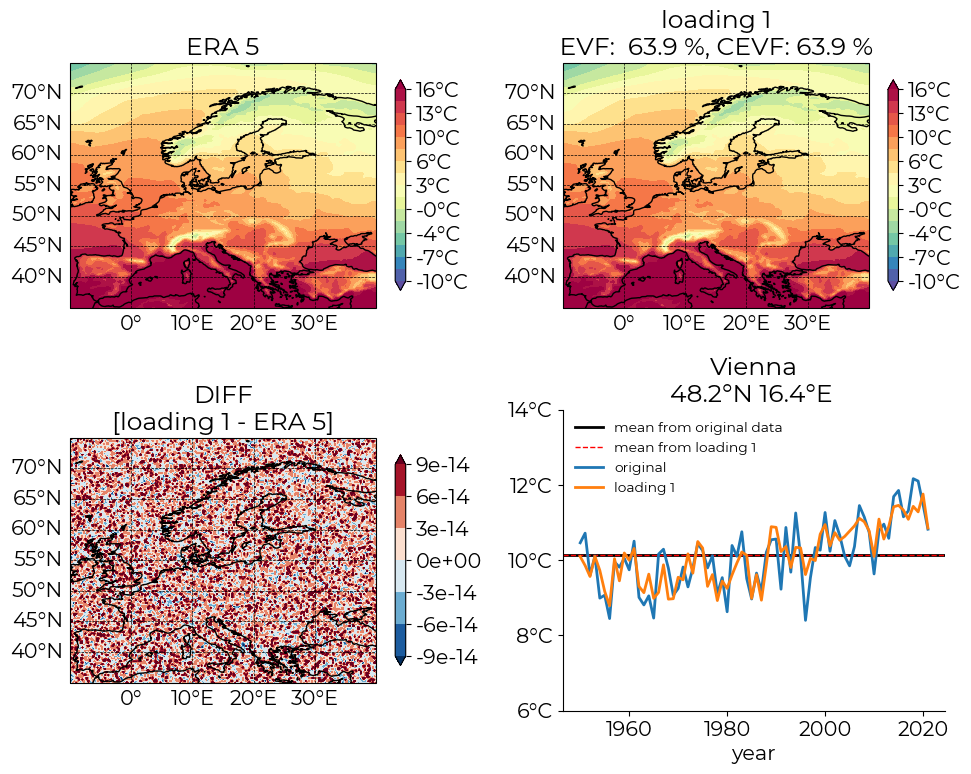

In [428]:
f3 = plt.figure(figsize=(10, 8))

axera = f3.add_subplot(221, projection=cpy.crs.PlateCarree())
pm.plot_map(regionmean.t2m - 273.15,
            ax=axera,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.0f°C',
            colormax=16, colormin=-10, colorlevels=17,
            title='ERA 5')

axload1 = f3.add_subplot(222, projection=cpy.crs.PlateCarree())
pm.plot_map(regionmean.pca_recostructed.sel(
            eigenvalues=region.eigenvalues[0]) - 273.15,
            ax=axload1,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.0f°C',
            colormax=16, colormin=-10, colorlevels=17,
            title='loading 1'
            + f'\n EVF:  {round(eigenvalues[0] * 100,1)} %,'
            + f' CEVF: {round(eigenvalues[:1].sum() * 100,1)} % ')

axdiff = f3.add_subplot(223, projection=cpy.crs.PlateCarree())
pm.plot_map(regionmean.pca_recostructed.sel(
            eigenvalues=region.eigenvalues[0]) - regionmean.t2m,
            ax=axdiff,
            extent=[lon1, lon2, lat1, lat2],
            lat='latitude', lon='longitude',
            fr='%.0e',
            cmap='RdBu_r',
            colormax=9e-14, colormin=-9e-14, colorlevels=7,
            title='DIFF\n[loading 1 - ERA 5]')

Vload1 = Vt2mERA.pca_recostructed.sel(eigenvalues=Vt2mERA.eigenvalues[0])
axyear = f3.add_subplot(224)
axyear.axhline(y=Vt2mERA.t2m.mean() - 273.15,
               color='black',
               linestyle='-',
               linewidth=2,
               label='mean from original data')
axyear.axhline(y=Vload1.mean() - 273.15,
               color='red',
               linestyle='--',
               linewidth=1,
               label='mean from loading 1')
axyear.plot(Vt2mERA.year,
            Vt2mERA.t2m - 273.15,
            label='original',
            linewidth=2)
axyear.plot(Vt2mERA.year,
            Vload1 - 273.15,
            label='loading 1',
            linewidth=2)
axyear.set_xlabel('year')
axyear.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f°C'))
axyear.legend(frameon=False, fontsize=10)
axyear.set_ylim((6, 14))
axyear.title.set_text('Vienna\n48.2°N 16.4°E ')

f3.tight_layout();

##### Check first loading
<ins>*Results:*</ins> <br>

    Max absolute difference: 5.52088454
    Max relative difference: 0.02083064 

In [183]:
print(testing.assert_allclose(rec[:, :, 0], regionreshape))

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 1866236 / 1866312 (100%)
Max absolute difference: 5.52088454
Max relative difference: 0.02083064
 x: array([[271.681765, 271.746838, 271.808637, ..., 293.134999, 293.518787,
        293.734089],
       [271.505075, 271.570856, 271.63377 , ..., 293.046224, 293.430229,...
 y: array([[272.29369 , 272.362548, 272.427564, ..., 292.197943, 292.533809,
        292.714588],
       [270.766049, 270.836322, 270.902728, ..., 293.396689, 293.744973,...

##### Check last loading
<ins>*Results:*</ins> <br>
   with rtol=1e-07 : None <br>
   . <br>
   . <br>
   . <br>
   with rtol=1e-15 :
    
    Max absolute difference: 1.1937118e-12
    Max relative difference: 4.37096812e-15

In [171]:
print(testing.assert_allclose(rec[:, :, -1], regionreshape))

None


In [181]:
print(testing.assert_allclose(rec[:, :, -1], regionreshape, rtol=1e-15))

AssertionError: 
Not equal to tolerance rtol=1e-15, atol=0

Mismatched elements: 29 / 1866312 (0.00155%)
Max absolute difference: 1.1937118e-12
Max relative difference: 4.37096812e-15
 x: array([[272.29369 , 272.362548, 272.427564, ..., 292.197943, 292.533809,
        292.714588],
       [270.766049, 270.836322, 270.902728, ..., 293.396689, 293.744973,...
 y: array([[272.29369 , 272.362548, 272.427564, ..., 292.197943, 292.533809,
        292.714588],
       [270.766049, 270.836322, 270.902728, ..., 293.396689, 293.744973,...

In [441]:
# calculate matched elements with rtol=1e-7
rtol = 1e-7
N = loadings.shape[0] * loadings.shape[1]
matched = np.zeros(loadings.shape[0]) + np.nan
for load in range(loadings.shape[0]):
    matched[load] = np.isclose(rec[:, :, load], regionreshape, rtol=rtol).sum()

# in %
percmatched = (matched / N) * 100

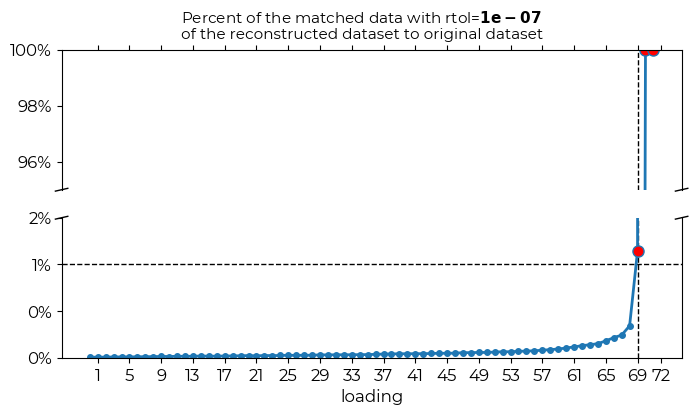

In [442]:
# formatting plot
font = {'sans-serif': 'Montserrat', 'size': 12}
axes = {'spines.top': True, 'spines.right': True}
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', linewidth=1)

f4, (axtop, axbottom) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# indicate loadings where matched >= 1%
axtop.axvline(x=69, color='black', linestyle='--', linewidth=1)
axbottom.axvline(x=69, color='black', linestyle='--', linewidth=1)
axbottom.axhline(y=1, color='black', linestyle='--', linewidth=1)

# plot % matched data
axtop.plot(percmatched,
           marker='o', markersize=8, markerfacecolor='red',
           linewidth=2)
axbottom.plot(percmatched,
              marker='o', markersize=4,
              linewidth=2)
axbottom.plot(69, percmatched[-3],
              marker='o', markersize=8,
              markerfacecolor='red', markeredgecolor='tab:blue',
              linewidth=2)

'''AXES'''
# set xticks label
axbottom.set_xticks(np.append(np.arange(1, 72, 4), 72))
axtop.set_xticks(np.append(np.arange(1, 72, 4), 72))

# limit the view
axtop.set_ylim(95, 100)
axbottom.set_ylim(0, 1.5)

# yticks in %
axtop.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axbottom.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# hide the spines between axtop and axbottom
axtop.spines['bottom'].set_visible(False)
axbottom.spines['top'].set_visible(False)
axtop.xaxis.tick_top()
axtop.tick_params(labeltop=False)
axbottom.xaxis.tick_bottom()

# add diagonal lines at yaxes
d = .01  # how big

# to the top axes
kwargs = dict(transform=axtop.transAxes, color='k', clip_on=False)
axtop.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axtop.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
# switch to the bottom axes
kwargs.update(transform=axbottom.transAxes)
axbottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axbottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagona

'''LABELS'''
axbottom.set_xlabel('loading')
f4.suptitle('Percent of the matched data with '
            + r"rtol=$\bf{" + str(rtol) + "}$"
            + '\nof the reconstructed dataset to original dataset',
            fontsize=11);

### task 5: Publication of your code on GitHub

##### Check flake8

###### flake8 for .py

In [458]:
%%bash
flake8 plotmap.py
flake8 fcmip6.py

###### flake8 for .ipynb
***NOTE: --ignore=E402,E703,W503,E999***

    E402 module level import not at top of file 
         -> stylistically challenging for Jupyter Notebook (title,...)
    E703 statement ends with a semicolon 
         -> don't want to print data before plots
    W503 line break before binary operator 
         -> changed on April 16th, 2016 
         -> NOW: line breaks should occur before the binary operator
    E999 SyntaxError: invalid syntax
         -> problem with %%bash 